In [2]:
# Load MNIST dataset
# https://en.wikipedia.org/wiki/MNIST_database

from keras.datasets.mnist import load_data

(train_X, train_y), (test_X, test_y) = load_data()

In [3]:
print('Train', train_X.shape, train_y.shape)
print('Test', test_X.shape, test_y.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


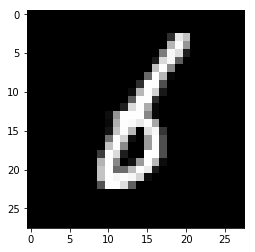

In [5]:
from matplotlib import pyplot

# plot raw pixel data
pyplot.imshow(train_X[256], cmap='gray')

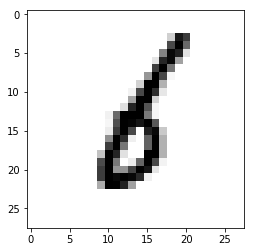

In [6]:
pyplot.imshow(train_X[256], cmap='gray_r')

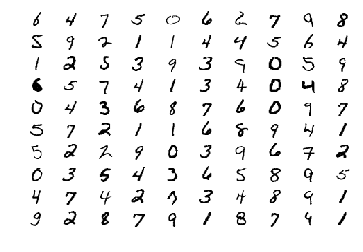

In [7]:
# plot images from the training dataset
for i in range(100):
    pyplot.subplot(10, 10, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(train_X[256+i], cmap='gray_r')
pyplot.show()

In [8]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    #Convolution Layer
    #Dropout used to prevent overfitting
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = define_discriminator()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

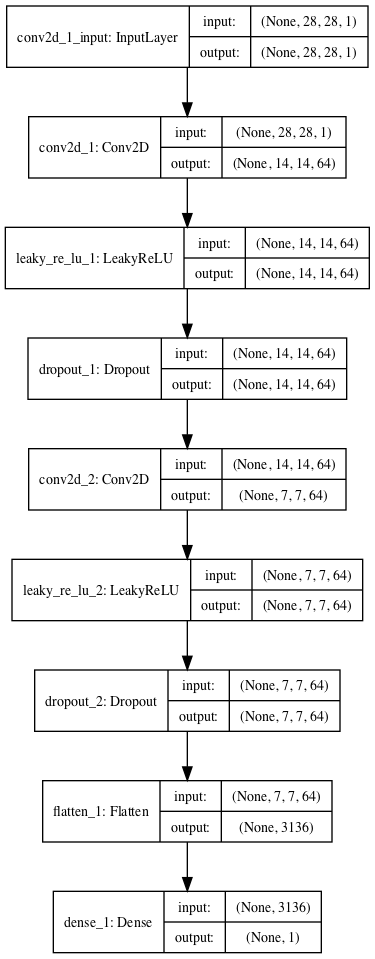

In [10]:
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils.vis_utils import plot_model

#SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)